# Bandit Algorithms vs AB Tests
[J. Nathan Matias](https://natematias.com), April 3, 2019

This notebook is part of [SOC412, Designing Field Experiments at Scale](https://natematias.com/courses/soc412/syllabus.html)

In [330]:
%matplotlib inline
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
import scipy                      # Scipy for confidence intervals of the mean
from dateutil import *            # I prefer dateutil for parsing dates
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
import statsmodels.stats as stats # access to ttest_ind
from collections import Counter, defaultdict   # Counter is useful for grouping and counting
import string, copy

cbbPalette = ["#000000", "#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]

## Simulate Data for Multiple Arms
In this part of the code, we simulate the potential outcomes for each participant across four possible conditions, each of which has a different normally distributed payoff.

In [18]:
## this method returns a pandas dataframe that contains
## all potential outcomes for a simulated set of possible interventions
## We use this simulation to test the multi-armed bandit

def sim_potential_outcomes(n, arm_means, arm_sds):
    dfhash = {}
    if(len(arm_means)!= len(arm_sds)):
        raise Exception("arm_means and arm_sds do not have the same length")
    elif(len(arm_means) > len(string.ascii_lowercase)):
        raise Exception("more arms requested than lowercase letters in ASCII *blush*")
    i = 0
    for mean in arm_means:
        key = string.ascii_lowercase[i]
        dfhash[key] = np.random.normal(mean,arm_sds[i], n)
        i += 1
    return pd.DataFrame(dfhash)

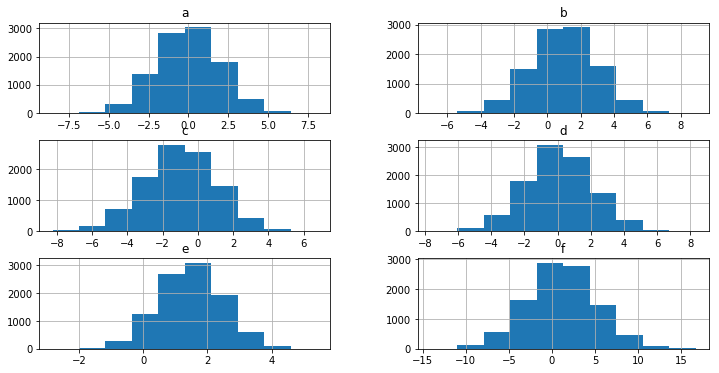

In [447]:
payoff_means = [0, 1, -1, 0.1, 1.5, 1.2]
payoff_sds   =  [2,2,2,2,1,4]
sim_df = sim_potential_outcomes(10000, payoff_means, payoff_sds)
sim_df.hist(bins=10, figsize=(12,6))
plt.show()

### What is the maximum outcome from perfect knowledge?
To achieve the maximum average outcome, we would invest only in arm E, which has a payoff of 1.5 on average. So the maximum average payout would be N * 1.2. The minimum average payout would be N * -1, if we put all resources into arm C. Those are the upper and lower bounds of what is possible with these arms.

## What would be the total payout of doing an A/B test if we waited for statistical significance before making a decision?
The first step of determining this is to do a power analysis. I could do this in the code (I started below), but instead, I'm going to use [the egap power calculator](https://egap.shinyapps.io/power-app/). This power calculator only compares betwen two arms, and I'm short on time, so my estimate is actually an under-estimate. To reach 80% power with a 0.3 effect size with one arm having a variance of 4, we would need "at least 5582" observations (just between those two arms), which means that for a six-arm experiment, we might need 16,746 observations to be able to make a decision (the true number is probably different from this, but let's work with this for the sake of argument).  

Now imagine that we had a total budget of 20,000 actions we could take and we had to spend 16,746 on the experiment, and we would genuinely learn the most effective arm of the experiment through that process. The total payoff we would get from the above simulated data would be as follows:

In [346]:
total_actions = 20000
per_arm = 2791

maximum_avg_payoff = total_actions * payoff_means[4]
abtest_avg_payoff  = per_arm * payoff_means[0] +     \
                     per_arm * payoff_means[1] +     \
                     per_arm * payoff_means[2] +     \
                     per_arm * payoff_means[3] +     \
                     per_arm * payoff_means[4] +     \
                     per_arm * payoff_means[5] +     \
                     payoff_means[4] * (total_actions - per_arm * 6)
random_avg_payoff      = np.mean(payoff_means) * total_actions

print("Maximum average payoff: {:0.2f}".format(maximum_avg_payoff))
print("Random average payoff: {:0.2f}".format(random_avg_payoff))
print("AB Test average payoff: {:0.2f}".format(abtest_avg_payoff))

Maximum average payoff: 30000.00
Random average payoff: 9333.33
AB Test average payoff: 12695.80


### Regret: the difference between the maximum average payoff and the payoff you got

## Bandit Algorithm Example: Upper Confidence Bound
The purpose of bandit algorithms is to minimize regret.

In this example, I implement a very simple **upper confidence bound** algorithm, which makes  one observation for each arm, and then always chooses the arm with the highest confidence interval. This bandit is operating in the "static" case where we don't expect the payoff from these arms to be changing. The bandit takes the following steps:

* for the first # trials, **sample randomly from the arms** to get information about the distribution of each arm
* for all subsequent trials, "pull" the arm with the **highest upper confidence bound**

You won't want to use this bandit in practice without substantial modification, but it's a simple illustration of an approach that makes intuitive sense to frequentist statisticians.

In [349]:
def ucb_bandit(num_arms, min_arm_obs, num_trials, all_payoff_means, potential_outcomes):
    arm_columns = string.ascii_lowercase[0:num_arms]
    bandit_history = {"arms":{}, "actions":[{"payoff":0, "regret":0, "arm":None, "arm_payoff":None}]}
    max_avg_payoff = max(all_payoff_means)
    
    for arm in arm_columns:
        bandit_history["arms"][arm] = []

    for i in range(num_trials):
        trial = i

        arms_under_min = [key for key in bandit_history["arms"].keys() 
                          if len(bandit_history["arms"][key])<min_arm_obs]

        ## choose a random arm if we are below the minimum observations
        if(len(arms_under_min)>0):
            next_arm = np.random.choice(arms_under_min, 1)[0]
            ## now take the potential outcome from the chosen arm
            ## reveal it and add it to the history of the bandit
            arm_payoff = potential_outcomes[next_arm][i]
            bandit_history["arms"][next_arm].append(
                arm_payoff
            )
            
            bandit_history["actions"].append({
                "arm": next_arm,
                "arm_payoff": arm_payoff,
                "payoff": bandit_history["actions"][-1]['payoff'] + arm_payoff,
                "regret": bandit_history["actions"][-1]['regret'] + (max_avg_payoff - arm_payoff)
            })

        ## otherwise choose based on the highest upper confidence interval
        else:
            upr_confint = {}
            for col in arm_columns:
                upr_confint[np.mean(bandit_history["arms"][col]) + 1.96 * np.std(bandit_history["arms"][col])] = col
            top_arm = upr_confint[np.max(list(upr_confint.keys()))]

            ## now take the potential outcome from the chosen arm
            ## reveal it and add it to the history of the bandit
            arm_payoff = potential_outcomes[top_arm][i]
            bandit_history["arms"][top_arm].append(
                arm_payoff
            )
            
            bandit_history["actions"].append({
                "arm": next_arm,
                "arm_payoff": arm_payoff,
                "payoff": bandit_history["actions"][-1]['payoff'] + arm_payoff,
                "regret": bandit_history["actions"][-1]['regret'] + (max_avg_payoff - arm_payoff)
            })

            
    return bandit_history

#### Plot the cumulative regret from multiple runs of the upper confidence bound algorithm

In [441]:
num_trials = 500
test_run_count = 10
min_arm_obs = 1

## initialize histories with the payoff from random selection
histories = []
histories.append({"payoff":[], "regret":[]})
payoff_mean = np.mean(payoff_means)
max_payoff = max(payoff_means)
for i in range(num_trials):
    histories[0]['payoff'].append(i * payoff_mean)
    histories[0]['regret'].append(i * max_payoff - i * payoff_mean)
histories[0]['final_arm']  = "RANDOM"

## conduct num_trials bandit runs
for i in range(test_run_count):
    history = ucb_bandit(num_arms=len(payoff_means), min_arm_obs=min_arm_obs, num_trials = num_trials, all_payoff_means = payoff_means, 
               potential_outcomes = sim_df)
    payoffs = [x['payoff'] for x in history['actions']]
    regrets = [x['regret'] for x in history['actions']]
    histories.append({"payoff": payoffs, "regret": regrets, "final_arm":history['actions'][-1]['arm']})

Text(0.5, 1.0, 'Cumulative regret over multiple runs')

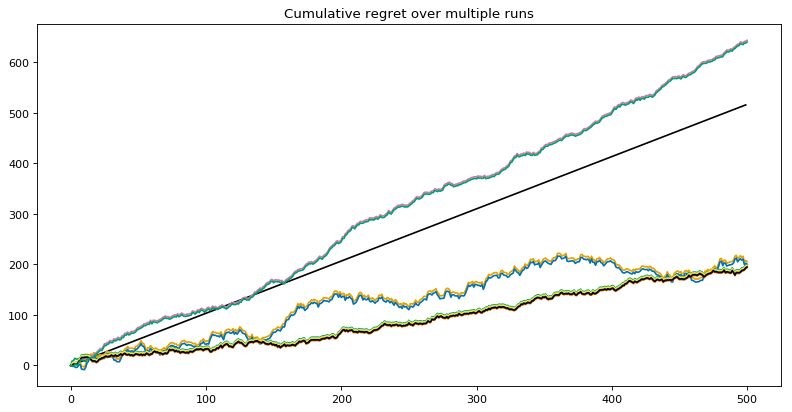

In [442]:
plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
#plt.ylim(0,3000)
for i in range(test_run_count):
    plt.plot(histories[i]['regret'], cbbPalette[i % 8])
plt.title("Cumulative regret over multiple runs")

## Scratch Area for Methods I Didn't Use

In [153]:
## randomly assign each arm and reveal the outcome 
## for up to N observations
def assign_and_reveal(n, arms, sim_df):
    sdf = copy.copy(sim_df)
    sdf['condition'] = pd.Series([string.ascii_lowercase[i] for i in np.random.choice(arms, len(sdf))])
    conditions = []
    outcomes = []
    i = 0
    for index, row in sdf.iterrows():
        if(i>=n):
            continue
        conditions.append(row['condition'])
        outcomes.append(row[row['condition']])
        i+= 1
    return pd.DataFrame({"condition":conditions, "outcome":outcomes})

In [154]:
def simulate_comparisons(n, arms, sim_df):
    if(n % arms != 0):
        raise Exception("n should be divisible by arms with no remainder")
    sim_reveal = assign_and_reveal(n, 6, sim_df)
    results = defaultdict(lambda: {"comp":None, "tstat":None, "pvalue":None})
    for a in string.ascii_lowercase[0:arms]:
        for b in string.ascii_lowercase[0:arms]:
            if(a == b):
                continue
            test = stats.weightstats.ttest_ind(sim_reveal[sim_reveal['condition'] == a]['outcome'].tolist(), 
                                sim_reveal[sim_reveal['condition'] == b]['outcome'].tolist())
            key = a + b
            results[key]['comp'] = key
            results[key]['tstat'] = test[0]
            results[key]['pvalue'] = test[1]
    return results

## You are Free to Copy & Reuse this Code¶ 
Copyright 2019 J. Nathan Matias

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.